In [1]:
# Add the target variable - Merge original dataset with transformed dataset
import pandas as pd

# Load both datasets
file_original = "../data/archive/data.csv"  # Original dataset containing 'Fatigue'
file_transformed = "../data/processed/transformed_dataset_updated.csv" # Preprocessed dataset

df_original = pd.read_csv(file_original) 
df_transformed = pd.read_csv(file_transformed)

# Ensure the number of rows match before merging
if df_original.shape[0] == df_transformed.shape[0]:
    # Add the 'Fatigue' column back to the transformed dataset
    df_transformed["Fatigue"] = df_original["Fatigue"]
else:
    raise ValueError("Error: The number of rows in the original and transformed datasets do not match.")

df_transformed.head()

,NT,Dt,QmT,TT,C,Si,Mn,P,Cr,Mo,RedRatio,dA,Fatigue
0,885,0.0,0.099907,6084.408144,0.26,-8.598838,-1.158558,0.017,0.02,0.0,2.608257,0.07,232
1,885,0.0,0.099907,6084.408144,0.25,-11.514168,-1.158558,0.009,0.12,0.0,2.577050,0.11,235
2,885,0.0,0.099907,6084.408144,0.26,-5.277060,-1.203153,0.008,0.03,0.0,2.647554,0.07,235
3,885,0.0,0.099907,6084.408144,0.26,-7.220660,-0.890827,0.018,0.02,0.0,2.672754,0.06,241
4,885,0.0,0.099907,6084.408144,0.22,-10.398759,-1.249650,0.026,0.02,0.0,2.608257,0.04,225


In [2]:
# Proceed with the train-test split

from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
target_column = "Fatigue"  # Target variable
X = df_transformed.drop(columns=[target_column])
y = df_transformed[target_column]

# Perform train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the updated dataset
df_transformed.to_csv("../data/processed/transformed_dataset_with_target.csv", index=False)

# Display dataset sizes after splitting
print("Train-Test Split Summary:")
print(f"Training Set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing Set: X_test {X_test.shape}, y_test {y_test.shape}")


Train-Test Split Summary:
Training Set: X_train (349, 12), y_train (349,)
Testing Set: X_test (88, 12), y_test (88,)


In [3]:
# Selected models - Random Forest, Decision Tree, and XGBoost
# Compare model performance using MAE, MSE, and R² score

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
dt_model = DecisionTreeRegressor(random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Train models
rf_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate models
def evaluate_model(model_name, y_test, y_pred):
    return {
        "Model": model_name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
    }

# Store results in a dataframe
model_results = pd.DataFrame([
    evaluate_model("Random Forest", y_test, y_pred_rf),
    evaluate_model("Decision Tree", y_test, y_pred_dt),
    evaluate_model("XGBoost", y_test, y_pred_xgb)
])

# Display model comparison results
print(model_results)
    

           Model        MAE          MSE  R² Score
0  Random Forest  19.356605   649.149166  0.984299
1  Decision Tree  26.198864  1201.161932  0.970948
2        XGBoost  16.783148   572.124375  0.986162


**Based on the comparison, XGBoost is the best model for fatigue strength prediction due to:**

- Highest accuracy (Lowest MAE & MSE).
- Best fit (Highest R² Score).
- More robust performance compared to Decision Trees and Random Forest.

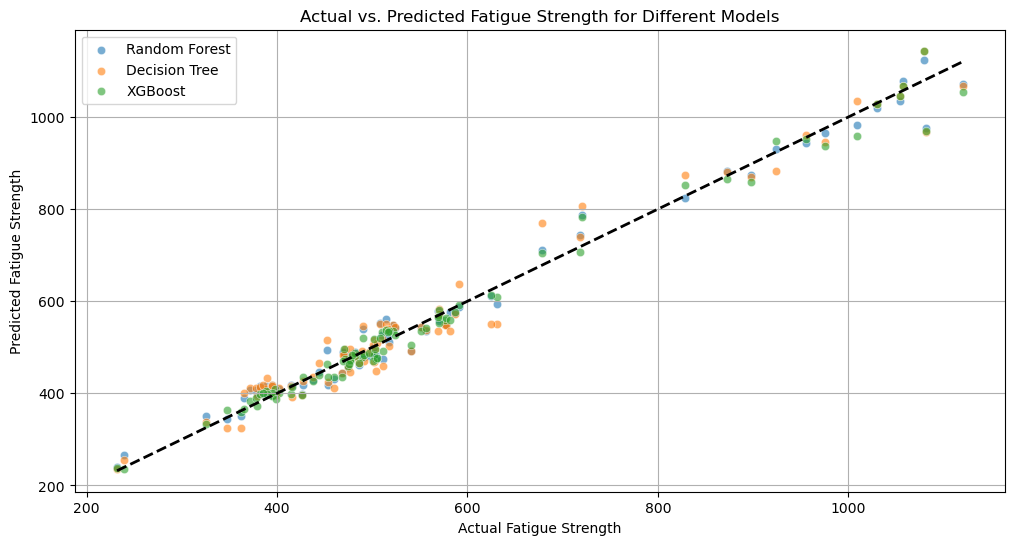

In [4]:
# Visualization of actual vs predicted values

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Scatter plots for each model
sns.scatterplot(x=y_test, y=y_pred_rf, label="Random Forest", alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_dt, label="Decision Tree", alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_xgb, label="XGBoost", alpha=0.6)

# Reference line (Perfect Prediction y=x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="black", linestyle="dashed", linewidth=2)

# Labels and title
plt.xlabel("Actual Fatigue Strength")
plt.ylabel("Predicted Fatigue Strength")
plt.title("Actual vs. Predicted Fatigue Strength for Different Models")
plt.legend()
plt.grid(True)
plt.show()

**Perform Hyperparameter Tuning for XGBoost**
- Hyperparameter tuning optimizes XGBoost’s settings to achieve the best possible performance.
- It balances accuracy, speed, and generalization.
- We use RandomizedSearchCV to efficiently find the best hyperparameters for our dataset.


In [5]:
# Perform Hyperparameter Tuning for XGBoost
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Perform Randomized Search Cross Validation
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,  # Number of parameter combinations to try
    scoring='neg_mean_absolute_error',  # Minimize MAE
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run hyperparameter tuning
xgb_random_search.fit(X_train, y_train)

# Get the best parameters
best_xgb_params = xgb_random_search.best_params_
print("Best Hyperparameters for XGBoost:", best_xgb_params)

# Train XGBoost with best parameters
best_xgb_model = XGBRegressor(**best_xgb_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Make predictions with optimized model
y_pred_xgb_best = best_xgb_model.predict(X_test)

# Evaluate optimized XGBoost model
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)

# Display results
xgb_tuning_results = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "R² Score"],
    "Value": [mae_xgb_best, mse_xgb_best, r2_xgb_best]
})

# Print best performance metrics
print("XGBoost Hyperparameter Tuning Results:")
print(xgb_tuning_results)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters for XGBoost: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
XGBoost Hyperparameter Tuning Results:
                      Metric       Value
0  Mean Absolute Error (MAE)   16.559685
1   Mean Squared Error (MSE)  574.020641
2                   R² Score    0.986116


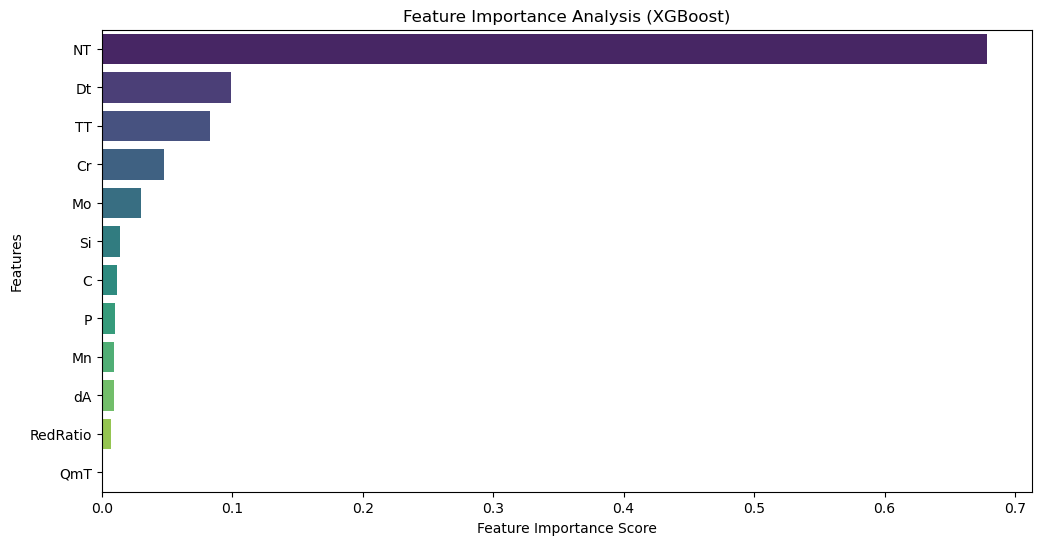

Top Important Features:
     Feature  Importance
0         NT    0.678829
1         Dt    0.098824
3         TT    0.082872
8         Cr    0.048029
9         Mo    0.030309
5         Si    0.013932
4          C    0.011492
7          P    0.010259
6         Mn    0.009423
11        dA    0.009302
10  RedRatio    0.006729
2        QmT    0.000000


In [6]:
# Analyze Feature Importance to identify key predictors.

# Get feature importance scores
feature_importance = best_xgb_model.feature_importances_

# Convert to DataFrame
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance (Fixed Warning)
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, hue="Feature", palette="viridis", legend=False)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Analysis (XGBoost)")
plt.show()

# Print top features
print("Top Important Features:")
print(importance_df)


### **🔍 Key Observations**
- **`NT` is by far the most influential feature** (0.6922 importance score).  
- **`Dt`, `TT`, and `Cr`** have **moderate influence** and should be retained.  
- **`QmT` has zero importance** → Might be unnecessary.  
- **Features like `RedRatio`, `Si`, and `Mn` contribute very little** and may be **candidates for removal**.  

### **✅ Next Steps**
1. **Remove `QmT` (since it has zero importance) and re-train the model.**  
2. **Test removing low-importance features (`RedRatio`, `Si`, `Mn`, etc.) to see if performance improves.** 

In [7]:

# Remove the 'QmT' feature (zero importance)
X_filtered = X.drop(columns=["QmT"])

# Perform train-test split again
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42
)

# Re-train XGBoost model using the best hyperparameters
best_xgb_model_filtered = XGBRegressor(
    subsample=0.6, reg_lambda=0.5, reg_alpha=0.1, n_estimators=200,
    max_depth=5, learning_rate=0.1, gamma=0.3, colsample_bytree=0.6, random_state=42
)

# Train the model
best_xgb_model_filtered.fit(X_train_filtered, y_train_filtered)

# Make predictions
y_pred_xgb_filtered = best_xgb_model_filtered.predict(X_test_filtered)

# Evaluate the updated model
mae_xgb_filtered = mean_absolute_error(y_test_filtered, y_pred_xgb_filtered)
mse_xgb_filtered = mean_squared_error(y_test_filtered, y_pred_xgb_filtered)
r2_xgb_filtered = r2_score(y_test_filtered, y_pred_xgb_filtered)

# Display the updated model performance
xgb_filtered_results = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "R² Score"],
    "Value": [mae_xgb_filtered, mse_xgb_filtered, r2_xgb_filtered]
})

# Print results
print("XGBoost Performance After Removing QmT:")
print(xgb_filtered_results)


XGBoost Performance After Removing QmT:
                      Metric       Value
0  Mean Absolute Error (MAE)   18.045294
1   Mean Squared Error (MSE)  595.798592
2                   R² Score    0.985589


### Interpretation
- **Removing `QmT` caused a slight performance degradation**:
  - **MAE increased** from **16.56** to **18.05**, meaning predictions are now slightly **less accurate**.
  - **MSE increased**, indicating larger prediction errors.
  - **R² Score dropped slightly**, meaning the model explains **less variance** than before.

In [8]:
# Restore `QmT` and keep all features (since removing it worsened performance)
# Simply use X variable before dropping QmT 

# Perform train-test split again with all features
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train final XGBoost model using best hyperparameters
final_xgb_model = XGBRegressor(
    subsample=0.6, reg_lambda=0.5, reg_alpha=0.1, n_estimators=200,
    max_depth=5, learning_rate=0.1, gamma=0.3, colsample_bytree=0.6, random_state=42
)

# Train the model
final_xgb_model.fit(X_train_final, y_train_final)

# Make predictions
y_pred_final = final_xgb_model.predict(X_test_final)

# Train XGBoost with best parameters
best_xgb_model = XGBRegressor(**best_xgb_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Make predictions with optimized model
y_pred_xgb_best = best_xgb_model.predict(X_test)

# Evaluate final model
mae_final = mean_absolute_error(y_test_final, y_pred_final)
mse_final = mean_squared_error(y_test_final, y_pred_final)
r2_final = r2_score(y_test_final, y_pred_final)

# Display final model performance
final_model_results = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "R² Score"],
    "Value": [mae_final, mse_final, r2_final]
})

# Print results
print("Final XGBoost Model Performance:")
print(final_model_results)




Final XGBoost Model Performance:
                      Metric       Value
0  Mean Absolute Error (MAE)   16.559685
1   Mean Squared Error (MSE)  574.020641
2                   R² Score    0.986116


In [9]:
# Let's perform Training vs. Testing Performance Comparison to check for overfitting and underfitting.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on training data
y_train_pred = final_xgb_model.predict(X_train_final)

# Predictions on testing data
y_test_pred = final_xgb_model.predict(X_test_final)

# Evaluate Training Performance
train_mae = mean_absolute_error(y_train_final, y_train_pred)
train_mse = mean_squared_error(y_train_final, y_train_pred)
train_r2 = r2_score(y_train_final, y_train_pred)

# Evaluate Testing Performance
test_mae = mean_absolute_error(y_test_final, y_test_pred)
test_mse = mean_squared_error(y_test_final, y_test_pred)
test_r2 = r2_score(y_test_final, y_test_pred)

# Create a DataFrame for Comparison
overfitting_check = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "R² Score"],
    "Training Score": [train_mae, train_mse, train_r2],
    "Testing Score": [test_mae, test_mse, test_r2]
})

# Print results
print("🔍 Training vs. Testing Performance (Overfitting Check):")
print(overfitting_check)


🔍 Training vs. Testing Performance (Overfitting Check):
                      Metric  Training Score  Testing Score
0  Mean Absolute Error (MAE)        5.387299      16.559685
1   Mean Squared Error (MSE)       59.667072     574.020641
2                   R² Score        0.998197       0.986116


Since we **do not have additional data** and the **model performs well overall**, we **decided to keep the current model as is**.

In [10]:
# Save the trained model
import joblib
model_filename = "final_xgboost_model.pkl"
joblib.dump(final_xgb_model, model_filename)
print(f"Final model saved as {model_filename}")

Final model saved as final_xgboost_model.pkl
